# Task 1: Grocery Item Categorization with Decision Tree

**Reference:**
Decision Tree Tutorial for Beginners | Simple ML Explained with an Example:
https://youtu.be/5NTrME5v1lo

**Goal:** Create a simple decision tree model that predicts grocery item categories based on item names.

**Approach:**
- Extract features from item names (character based features)
- Train a decision tree classifier
- Evaluate the model performance

**Reasoning For Choice:**
I considered using a neural network for this classification problem, but after thinking about it, I decided to go with a decision tree instead. Neural networks seemed like they might be overkill for this problem, as I read that neural networks need a lot of data to work well, and with only 225 items in my dataset, I was worried it wouldn't have enough examples to learn from. Decision trees, on the other hand, are simpler to understand and can work with smaller datasets. Plus, one of the biggest advantages is that I can actually visualize the tree and see exactly how it makes decisions like if the word length is less than 6 and starts with 'm', then check if it has more than 2 vowels which helps me understand what the model is learning. With neural networks, it's more of a black box where you just get predictions but can't really see the reasoning.

The main downside is that decision trees can overfit easily, which I noticed when my training accuracy was much higher than test accuracy in **Step 5**, but at least I can see what's happening and adjust the parameters.


In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 1: Load and Explore the Data

## Data Collection and Processing

**What kind of data do I need?** For this grocery categorization task, I need a dataset that contains pairs of grocery item names and their corresponding categories. The data should have two main components:
- **Item names**: The text names of grocery items (like "apple", "chicken", "milk")
- **Category labels**: The category each item belongs to (like "Produce", "Meat & Seafood", "Dairy & Eggs")

**Where did I get the data?** I'm using a dataset from Hugging Face (https://huggingface.co/datasets/AmirMohseni/GroceryList) that contains 225 grocery items across 15 different categories. This dataset was already collected and organized, which saved me time.

**How much data do I need?** With only 225 items, this is actually a pretty small dataset. Ideally, I'd want more examples, maybe 1000+ items would be better for training a more robust model. However, since decision trees can work with smaller datasets compared to neural networks, I decided to proceed with what I have. The dataset has items distributed across 15 categories, with each category having between 12-18 examples, which is fairly balanced but still quite small.

**How will I process the data?** The raw data comes as a CSV file with item names and categories. I'll need to:
1. Load the CSV file using pandas
2. Extract features from the item names (since the model can't work with raw text, I need to convert names into numerical features like word length, character patterns, etc.)
3. Encode the category labels into numbers (the model needs numbers, not text labels)
4. Split the data into training and testing sets (80% for training, 20% for testing)

The feature extraction is crucial. I'm converting text into simple numerical features like word length, first/last character values, vowel counts, etc. This is a limitation because I'm not capturing the actual meaning of words, just their spelling patterns, but it's a good starting point.

![Step 1 results](../resultsimages/task1results/task1step1results.png)

In [21]:
# Load the grocery data
df = pd.read_csv('data.csv')

# Display basic information
print(f"Total items in dataset: {len(df)}")
print(f"\nNumber of categories: {df['Category'].nunique()}")
print("\nFirst 10 items:")
print(df.head(10))
print("\nCategory distribution:")
print(df['Category'].value_counts())


Total items in dataset: 225

Number of categories: 15

First 10 items:
       Item Category
0     apple  Produce
1    banana  Produce
2    orange  Produce
3   lettuce  Produce
4    carrot  Produce
5  broccoli  Produce
6    tomato  Produce
7   spinach  Produce
8    grapes  Produce
9      pear  Produce

Category distribution:
Category
Pantry                 18
Meat & Seafood         17
Produce                17
Dairy & Eggs           16
Bakery                 16
Personal Care          16
Snacks                 16
Condiments & Sauces    15
Beverages              15
Pet Supplies           14
Household              14
Pasta & Grains         14
Deli                   13
Frozen Foods           12
Canned Goods           12
Name: count, dtype: int64


## Step 2: Feature Extraction

The model can't work with raw text like "apple" or "milk", so I turn each item name into a set of features that the decision tree can use.

**Why I chose these features:**

- **Length of the item name**: Short words like "milk" or "bread" often point to certain categories (e.g. dairy, bakery), while longer names like "broccoli" or "spinach" might be produce. So length felt like a useful signal.

- **First and last character (as ASCII values)**: I encode the first and last letter as numbers so the tree can learn patterns like starts with m (milk, mustard) or ends with e (apple, cheese). It's a simple way to capture how words start and end without dealing with full text.

- **Number of vowels and consonants**: Different categories sometimes have different letter patterns. I thought vowel/consonant counts might help separate words that "look" different even when they're similar length.

- **Number of spaces**: Multi word items (e.g. "ice cream", "olive oil") get a higher count here. That can help the model treat phrases a bit differently from single words.

- **Average character value**: This is basically the average ASCII value of the letters in the name. It gives a rough idea of which part of the alphabet the word uses, which might pick up some spelling patterns that correlate with categories.

I know these features don't capture meaning at all "apple" and "apply" would look quite similar but for this small task I wanted something interpretable and fast. If I had more data later, I could try richer text features or embeddings.

![Step 2 results](../resultsimages/task1results/task1step2results.png)


In [22]:
def extract_features(item_name):
    """Extract simple features from item name"""
    item_lower = item_name.lower()
    
    features = []
    
    # Length of item name
    features.append(len(item_name))
    
    # First character (ASCII value)
    features.append(ord(item_lower[0]) if len(item_lower) > 0 else 0)
    
    # Last character (ASCII value)
    features.append(ord(item_lower[-1]) if len(item_lower) > 0 else 0)
    
    # Number of vowels
    vowels = 'aeiou'
    num_vowels = sum(1 for char in item_lower if char in vowels)
    features.append(num_vowels)
    
    # Number of consonants
    num_consonants = sum(1 for char in item_lower if char.isalpha() and char not in vowels)
    features.append(num_consonants)
    
    # Number of spaces
    features.append(item_name.count(' '))
    
    # Average character value
    if len(item_lower) > 0:
        features.append(sum(ord(c) for c in item_lower if c.isalpha()) / len([c for c in item_lower if c.isalpha()]) if any(c.isalpha() for c in item_lower) else 0)
    else:
        features.append(0)
    
    return features

# Extract features for all items
X = np.array([extract_features(item) for item in df['Item']])
print(f"Feature matrix shape: {X.shape}")
print(f"Sample features for '{df['Item'].iloc[0]}': {X[0]}")


Feature matrix shape: (225, 7)
Sample features for 'apple': [  5.  97. 101.   2.   3.   0. 106.]


## Step 3: Encode Labels and Split Data

**Why encode labels?** The decision tree algorithm needs numbers to work with, not text. Our categories are strings like "Produce" and "Dairy & Eggs", but the model can only understand numbers. So we use LabelEncoder to convert each category name into a number (like 0, 1, 2, etc.). It's basically just assigning each category a unique ID number that the model can use.

**Why split the data?** This is really important. we need to keep some data separate to test our model. If we train the model on ALL the data and then test it on the same data, the model would just memorize everything and look really good, but then fail when we give it new items it's never seen before. By splitting the data into training (80%) and testing (20%) sets, we can train on one part and then honestly evaluate how well it works on the other part. The `stratify=y` parameter makes sure each category is represented proportionally in both sets, which is important since some categories have fewer examples than others.

![Step 3 results](../resultsimages/task1results/task1step3results.png)


In [23]:
# Encode category labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Number of categories: {len(label_encoder.classes_)}")


Training set size: 180
Testing set size: 45
Number of categories: 15


## Step 4: Train Decision Tree Classifier

**Why these parameters?** I had to experiment a bit to find settings that work well with my dataset. Here's what I chose and why:

- **`max_depth=10`**: This limits how deep the tree can grow. Without a limit, the tree would keep splitting until it memorizes every single training example, which causes overfitting (it works great on training data but terrible on new data). I tried a few values and 10 seemed like a good balance. deep enough to learn patterns but not so deep that it just memorizes everything. With only 180 training examples, a very deep tree would definitely overfit.

- **`min_samples_split=5`**: This says a node needs at least 5 samples before it can be split further. This prevents the tree from creating splits based on just 1 or 2 examples, which would be too specific and not generalize well. Since some categories only have 12-18 examples total, requiring at least 5 samples per split helps keep the tree from getting too specific to the training data.

- **`min_samples_leaf=2`**: This means each leaf (final decision) needs at least 2 samples. This is another way to prevent overfitting... we don't want leaves that only represent a single example because that's basically memorization. Having at least 2 samples per leaf makes the model more general.

- **`random_state=42`**: This makes sure I get the exact same results every time I run the code. When a decision tree is building, sometimes it has to choose between multiple features that are equally good for splitting. Without setting random_state, it might pick different features each time, giving me a slightly different tree. By setting it to 42, I'm telling the algorithm "use this specific random seed," so it always makes the same choices. This is super helpful when I'm experimenting because I can compare results and know that any differences are from my changes, not from random chance.

![Step 4 results](../resultsimages/task1results/task1step4results.png)


In [24]:
# Create and train the decision tree
clf = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train the model
clf.fit(X_train, y_train)

print("Decision tree trained successfully!")

# --- Save model and encoder for Task 2 (reuse outcome of this task) ---
# Task 2 loads these files with joblib.load() so it uses this trained model
# without retraining. Files: decision_tree_model.joblib, label_encoder.joblib.
import joblib
joblib.dump(clf, "decision_tree_model.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")
print("Saved decision_tree_model.joblib and label_encoder.joblib for Task 2.")


Decision tree trained successfully!
Saved decision_tree_model.joblib and label_encoder.joblib for Task 2.


## Step 5: Evaluate the Model

**What do these accuracies mean?** After training the model, I need to see how well it's actually working. I calculate two different accuracies:

- **Training Accuracy**: This tells me how well the model performs on the data it was trained on (the 180 items it learned from). It's checking if the model remembers what it was taught. A high training accuracy means the model learned the patterns in the training data.

- **Testing Accuracy**: This is the more important one. It shows how well the model performs on completely new data it's never seen before (the 45 items we held back). This is the real test of whether the model can actually generalize and make good predictions on new grocery items.

**Why are they different?** If the training accuracy is much higher than the testing accuracy, it means the model is overfitting. It memorized the training examples too well and can't handle new data. Ideally, you want both accuracies to be similar and reasonably high. If there's a big gap, you might need to adjust the tree parameters (like reducing max_depth) to make the model less specific to the training data.

![Step 5 results](../resultsimages/task1results/task1step5results.png)


In [25]:
# Make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Training Accuracy: 0.6611 (66.11%)
Testing Accuracy: 0.1556 (15.56%)


**What is the classification report?** The accuracy score gives me an overall picture, but the classification report breaks down the performance for each category. This is really useful because it shows me which categories the model is good at predicting and which ones it struggles with. The report shows three metrics for each category:

- **Precision**: Out of all the items the model predicted as a certain category, how many were actually correct? For example, if the model predicted 4 items as "Bakery" and 1 was wrong, the precision would be 0.75 (3 out of 4 correct). High precision means when the model says something is a category, it's usually right.

- **Recall**: Out of all the items that actually belong to a category, how many did the model correctly identify? For example, if there are 3 "Bakery" items in the test set and the model found 1 of them, the recall would be 0.33 (1 out of 3). High recall means the model finds most of the items in that category.

- **F1-score**: This is a balance between precision and recall. It's useful when you want a single number that considers both metrics. A high F1-score means the model is doing well on both precision and recall for that category.

- **Support**: This just tells you how many items of each category were in the test set. It's helpful to see if some categories have very few examples, which might explain why the model struggles with them.

The report also shows averages at the bottom macro avg treats all categories equally, while weighted avg gives more weight to categories with more examples.

![Step 5 results (classification report)](../resultsimages/task1results/task1step5results2.png)

In [26]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))



Classification Report:
                     precision    recall  f1-score   support

             Bakery       0.25      0.33      0.29         3
          Beverages       0.11      0.33      0.17         3
       Canned Goods       0.00      0.00      0.00         2
Condiments & Sauces       0.00      0.00      0.00         3
       Dairy & Eggs       0.00      0.00      0.00         3
               Deli       0.00      0.00      0.00         3
       Frozen Foods       0.00      0.00      0.00         2
          Household       0.33      0.67      0.44         3
     Meat & Seafood       0.25      0.33      0.29         3
             Pantry       0.00      0.00      0.00         4
     Pasta & Grains       0.20      0.33      0.25         3
      Personal Care       0.33      0.33      0.33         3
       Pet Supplies       0.00      0.00      0.00         3
            Produce       0.00      0.00      0.00         4
             Snacks       0.00      0.00      0.00         3

c:\Users\User\miniconda3\envs\big-data-venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\miniconda3\envs\big-data-venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\miniconda3\envs\big-data-venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

## Step 6: Test with New Examples

**What are we doing here?** Now I want to see how the model performs on some common grocery items that I know the correct categories for. This is a practical way to check if the model makes sense. I can look at each prediction and see if it matches what I would expect.

**Looking at the results:** Some predictions are correct and some are wrong, which matches what we saw with the low testing accuracy (15.56%). The model got some right like "apple" -> Produce, "bread" -> Bakery, "pasta" -> Pasta & Grains, "soda" -> Beverages, and "chips" -> Snacks. But it also made some mistakes. "chicken" was predicted as Beverages instead of Meat & Seafood, "milk" was predicted as Meat & Seafood instead of Dairy & Eggs, and "toothpaste" was predicted as Bakery instead of Personal Care.

**Why are there mistakes?** The simple character-based features I'm using (like word length, first/last characters, vowel counts) aren't really capturing the semantic meaning of the words. For example, "chicken" and "soda" might have similar character patterns, so the model gets confused. The model is basically trying to categorize items based on how they're spelled rather than what they actually are, which is why it struggles. This shows the limitations of using only basic text features. To do better, I'd probably need to use more sophisticated techniques like word embeddings or include actual word meanings in the features.

![Step 6 results](../resultsimages/task1results/task1step6results.png)


In [27]:
# Test with some example items
test_items = ['apple', 'chicken', 'milk', 'bread', 'pasta', 'soda', 'chips', 'toothpaste', 'buns', 'sausage']

print("Predictions for test items:")
print("-" * 50)
for item in test_items:
    features = extract_features(item)
    prediction = clf.predict([features])[0]
    predicted_category = label_encoder.inverse_transform([prediction])[0]
    print(f"{item:15} -> {predicted_category}")


Predictions for test items:
--------------------------------------------------
apple           -> Produce
chicken         -> Beverages
milk            -> Meat & Seafood
bread           -> Bakery
pasta           -> Pasta & Grains
soda            -> Beverages
chips           -> Snacks
toothpaste      -> Bakery
buns            -> Snacks
sausage         -> Beverages


## Step 7: Visualize the Decision Tree

**Why visualize the tree?** This is one of the biggest strengths of decision trees. You can actually see how the model makes decisions! Unlike neural networks or other "black box" models where you just get predictions without understanding why, decision trees let you trace through the tree and see exactly what rules the model learned. For example, you can see "if the word length is less than 6, then check the first character, and if it's 'b', then it's likely Bakery." This interpretability is really valuable because it helps you understand what patterns the model found, which can help you improve the features or identify where the model might be making mistakes.

![Step 7 results](../resultsimages/task1results/task1step7results.png)


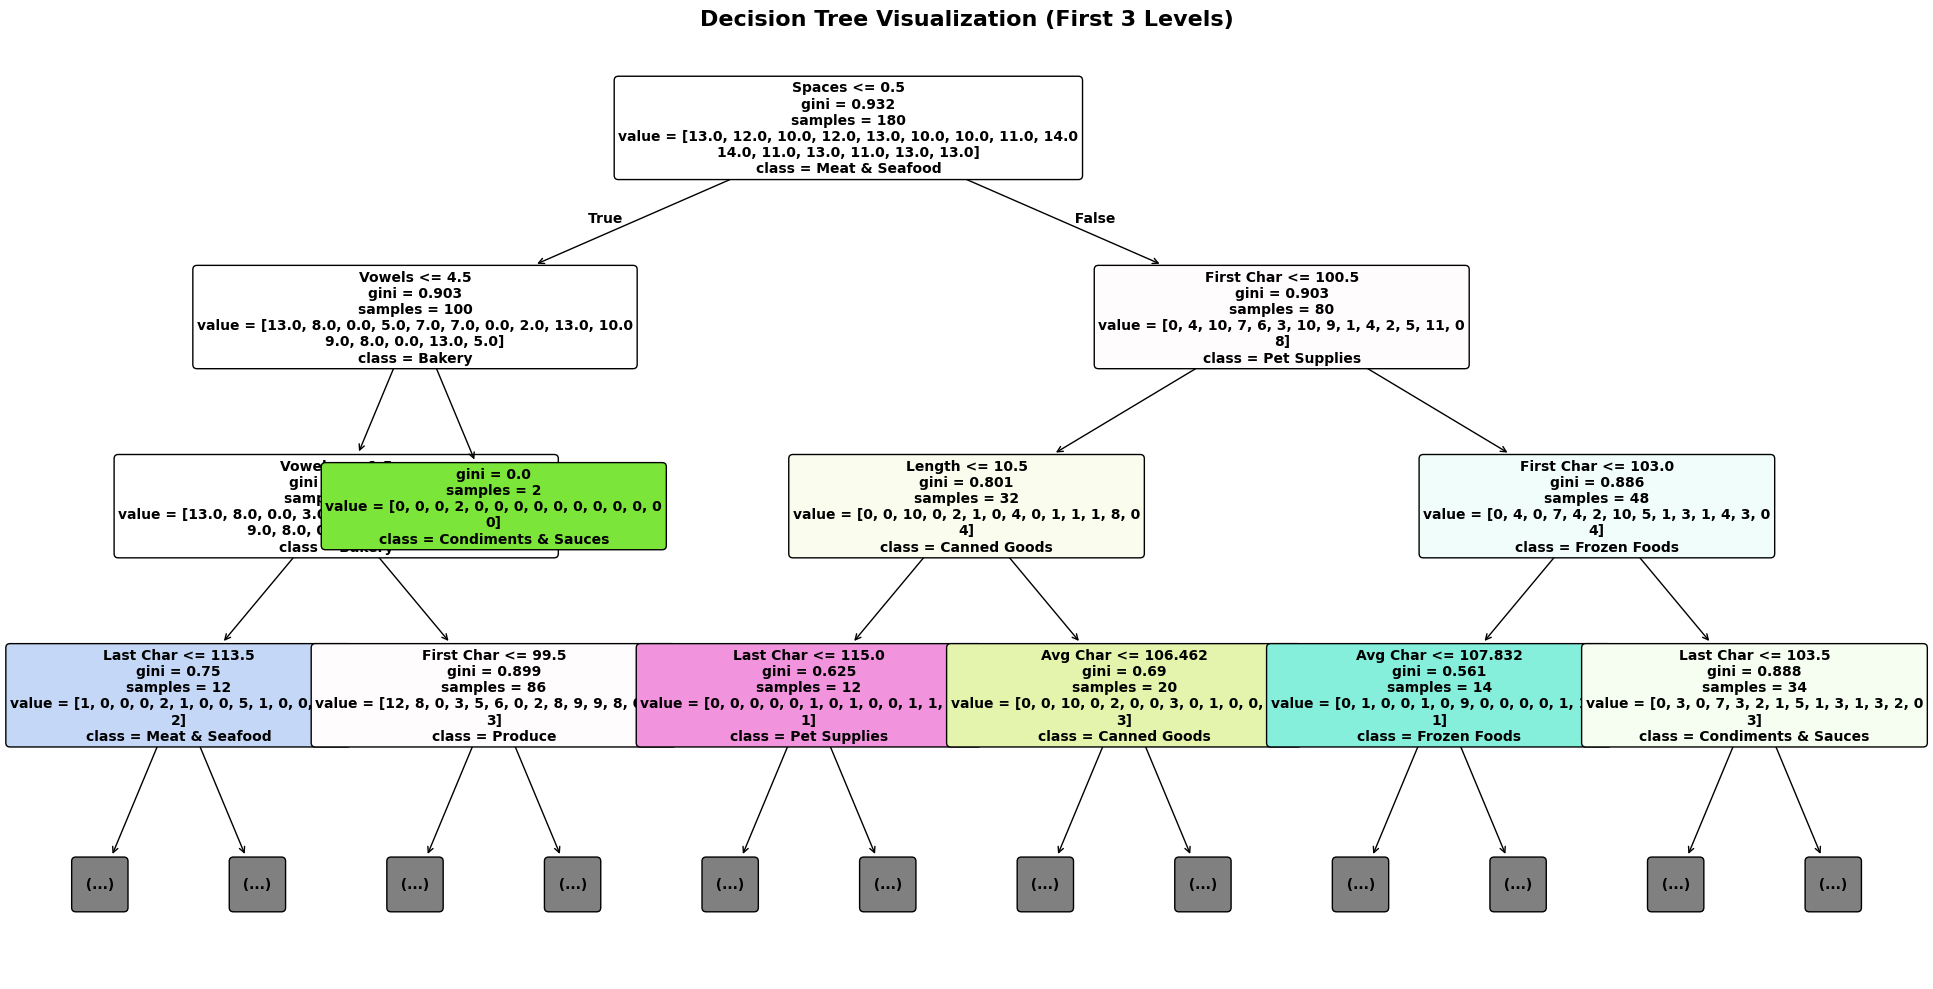

In [28]:
# Visualize the decision tree (first few levels)
plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf,
    max_depth=3,  # Show first 3 levels to keep it readable
    feature_names=['Length', 'First Char', 'Last Char', 'Vowels', 'Consonants', 'Spaces', 'Avg Char'],
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (First 3 Levels)", fontsize=16)
plt.tight_layout()
plt.show()


## Summary

This simple decision tree model uses basic features extracted from item names to predict grocery categories. The model learns patterns in:
- Item name length
- Character patterns (first/last characters)
- Vowel and consonant counts
- Other simple text features

You can experiment with:
- Different feature extraction methods
- Adjusting tree parameters (max_depth, min_samples_split, etc.)
- Using more sophisticated text features (TF-IDF, word embeddings, etc.)
